Nivell 1  ----Supervisat_Regressio 

- Exercici 1
Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

- Exercici 2
Compara’ls en base al MSE i al R2 .

- Exercici 3
Entrena’ls utilitzant els diferents paràmetres que admeten.

- Exercici 4
Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)


Nivell 2

- Exercici 5
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció


Nivell 3

- Exercici 6
No utilitzis la variable DepDelay a l’hora de fer prediccions

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline

In [3]:
flightsdf=pd.read_csv('DelayedFlights.csv', index_col=0) #a vegades cal posar index_col=0 si no fos detectat inicialment
flightsdf.info()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [90]:
## SIMPLIFICAR MEGABLOC de dades
#sumant delays es genera una nov columna agregant tots els retards a cada vol
#per DEFINICIO: Actual Elapsed Time=Taxi In+Taxi Out+Airtime operations ; 
#per DEFINICIO ArrivalDelay= carrierdelay+weatherdelay+NASdelay+LateAircraftdelay
flightsdf['delaytime']=flightsdf['CarrierDelay']+flightsdf['WeatherDelay']+flightsdf['NASDelay']+flightsdf['SecurityDelay']+flightsdf['LateAircraftDelay']+flightsdf['TaxiIn']+flightsdf['TaxiOut'] #sense DEPDELAY
#elimino els que NO han volat (airtime=0)
flightsdf.drop(flightsdf[flightsdf.AirTime==0].index, inplace=True) #, axis=0, inplace=True)
#elimino 'UniqueCarrier','FlightNum' , 'Origin','Dest',de la seleccio  perquè sabem que aporten poc, a no ser que fem classificadors 
flightsdf['DepDate'] = pd.to_datetime(flightsdf.Year*10000+flightsdf.Month*100+flightsdf.DayofMonth,format='%Y%m%d')

compactdf=pd.DataFrame(flightsdf, columns=['DepDate','DayOfWeek','CRSDepTime','DepDelay','ActualElapsedTime','Distance','delaytime','ArrDelay'])
compactdf.dropna(inplace=True) #puc eliminar els NaN en general o podria eliminar només els que no tenen retards
compactdf[100:110]

,DepDate,DayOfWeek,CRSDepTime,DepDelay,ActualElapsedTime,Distance,delaytime,ArrDelay
223,2008-01-03,4,2040,60.0,54.0,256,68.0,54.0
225,2008-01-03,4,1450,31.0,64.0,256,48.0,30.0
226,2008-01-03,4,1945,75.0,55.0,256,77.0,65.0
227,2008-01-03,4,1630,27.0,68.0,256,39.0,20.0
230,2008-01-03,4,1745,40.0,229.0,1910,43.0,24.0
232,2008-01-03,4,1600,30.0,293.0,2363,60.0,33.0
234,2008-01-03,4,1725,59.0,237.0,2027,51.0,36.0
235,2008-01-03,4,1630,46.0,74.0,345,49.0,35.0
236,2008-01-03,4,1855,33.0,66.0,345,31.0,19.0
238,2008-01-03,4,1730,11.0,84.0,345,42.0,15.0


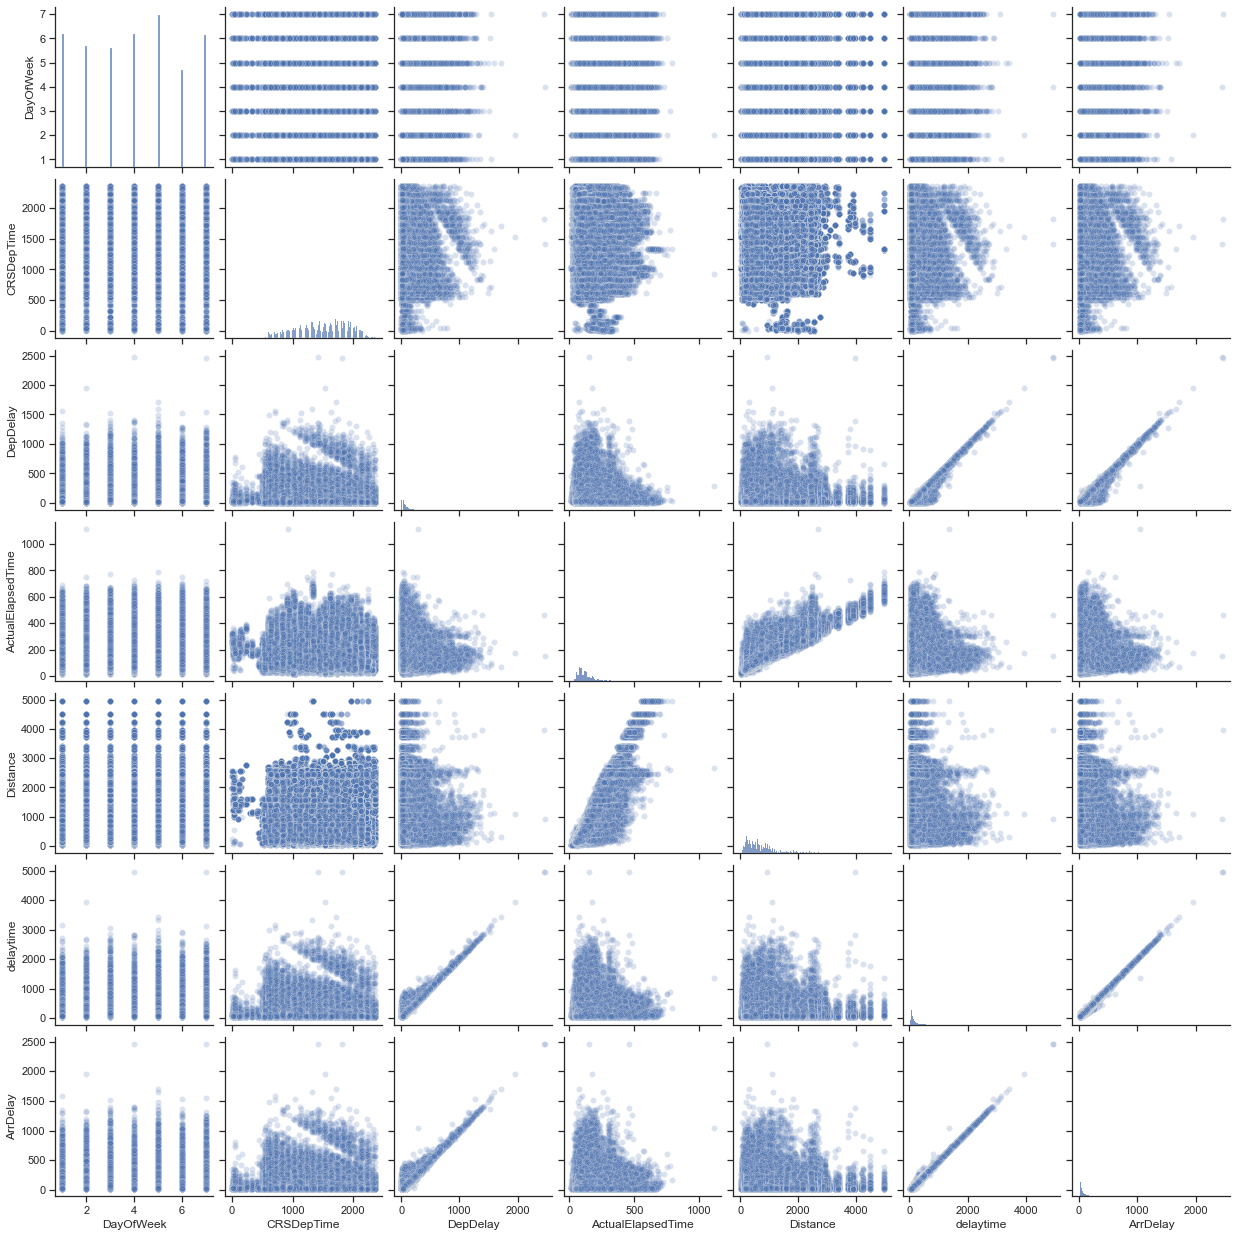

In [84]:
sns.set_theme(style="ticks")
sns.pairplot(compactdf,diag_kind='hist', plot_kws={'alpha': 0.2}) #diag kind="kde""hist""reg"scatter" , plot_kws=dict(marker="+", linewidth=1), diag_kws=dict(fill=False), si assignat a variable:df.map_lower(sns.kdeplot, levels=4, color=".2")
#pairplot(data, *, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None

#### anotar mètode pairgrid, molt customitzable

g = sns.PairGrid(penguins, diag_sharey=False)

g.map_upper(sns.scatterplot)

g.map_lower(sns.kdeplot)

g.map_diag(sns.kdeplot)

## sembla que la millor manera de preveure ArrDelay és via Delaytime (que la conté) o estirant de DepDelay, per tant, modelarem amb DepDelay mentre es pugui

In [50]:
X=compactdf[['DepDelay']] #'DepDate','DayOfWeek','CRSDepTime','ActualElapsedTime','Origin','Dest','Distance','delaytime' 
y=compactdf['ArrDelay']

In [51]:
X.shape # miro que els formats siguin adients

(1247483, 1)

In [52]:
y.shape

(1247483,)

In [53]:
model = LinearRegression() #genera variable model amb les components a modelar
model.fit(X, y) #calcula els pesos de les variables. Retorna "self". Retorna "model"
model = LinearRegression().fit(X, y) #redueix les dues operacions solapant mètodes a 1 linia
r_sq = model.score(X, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_) #matriu de coeficients de la regressió
y_pred=model.predict(X)
mean_squared_error(y, y_pred, multioutput='raw_values')

coefficient of determination: 0.9031151618556312
intercept: 5.740015664583396
slope: [0.96437171]


array([357.60723146])

## 2 model polinomic (tambe scikitlearn)

In [55]:
X = np.array(X).reshape((-1, 1)) ###INPUT BIDIMENSIONAL SEMPRE minim 1 col x n files!!!!
y = np.array(y)

In [56]:
X_ = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False).fit_transform(X) #inicialitzo les variables, poso els valors de x, x^2 ... per la regressio
print(X_)

[[  34. 1156.]
 [  67. 4489.]
 [  94. 8836.]
 ...
 [  30.  900.]
 [  57. 3249.]
 [  80. 6400.]]


In [58]:
model = LinearRegression().fit(X_, y)
r_sq = model.score(X_, y)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)

print('coefficients:', model.coef_)
y_pred=model.predict(X_)
mean_squared_error(y, y_pred, multioutput='raw_values')

coefficient of determination: 0.9037990969292766
intercept: 6.988289230083119
coefficients: [9.33302472e-01 8.47858946e-05]


array([355.08278973])

### No cal terme independent. demo

In [59]:
X_ = PolynomialFeatures(degree=2, interaction_only=False).fit_transform(X) #inicialitzo les variables, poso els valors de x, x^2 ... per la regressio
print(X_)
model = LinearRegression().fit(X_, y)
r_sq = model.score(X_, y)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)

print('coefficients:', model.coef_)
y_pred=model.predict(X_)
mean_squared_error(y, y_pred, multioutput='raw_values')

[[1.000e+00 3.400e+01 1.156e+03]
 [1.000e+00 6.700e+01 4.489e+03]
 [1.000e+00 9.400e+01 8.836e+03]
 ...
 [1.000e+00 3.000e+01 9.000e+02]
 [1.000e+00 5.700e+01 3.249e+03]
 [1.000e+00 8.000e+01 6.400e+03]]
coefficient of determination: 0.9037990969292766
intercept: 6.988289230082181
coefficients: [0.00000000e+00 9.33302472e-01 8.47858946e-05]


array([355.08278973])

### 3 incloent una altra variable al model

In [60]:
X=compactdf[['DepDelay', 'ActualElapsedTime']] #'DepDate','DayOfWeek','CRSDepTime','Origin','Dest','Distance','delaytime' 
y=compactdf['ArrDelay']
X, y = np.array(X), np.array(y) ## els transformo en arrays de NUMPY per al model

In [61]:
X_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X) #transformant dades d'entrada i generant model

In [62]:
model = LinearRegression().fit(X_, y) #fent el model multivariable

In [64]:
r_sq = model.score(X_, y)
intercept, coefficients = model.intercept_, model.coef_ #dades del model
print('coefficient of determination:', r_sq)

print('intercept:', intercept)

print('coefficients:', coefficients, sep='\n')
y_pred=model.predict(X_)
mean_squared_error(y, y_pred, multioutput='raw_values')

coefficient of determination: 0.9111626134394997
intercept: -5.20928472094657
coefficients:
[ 9.47113625e-01  1.00296629e-01  8.03356317e-05 -8.34329253e-05
 -6.36627320e-05]


array([327.90364795])

# EXERCICI 2 

### hi ha poca diferència. linial esta en R2=0,903 i MSE=357,6; quadratica 0,904 i 355,1; mentre que multivariable es nota una lleugera millora amb 0,911 i 327,9 respectivament. 


# EXERCICI 3

#### Afegint un entrenament al model. A priori, quan més petita és la mostra, major és la varaibilitat i menor la R2

In [67]:
X=compactdf[['DepDelay']] #'DepDate','DayOfWeek','CRSDepTime','ActualElapsedTime','Origin','Dest','Distance','delaytime' 
y=compactdf['ArrDelay']
### SPLIT en 2 jocs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [68]:
model = LinearRegression() #genera variable model amb les components a modelar
model.fit(X_train, y_train) #calcula els pesos de les variables. Retorna "self". Retorna "model"
model = LinearRegression().fit(X_train, y_train) #redueix les dues operacions solapant mètodes a 1 linia
r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_) #matriu de coeficients de la regressió
y_pred=model.predict(X_test)
mean_squared_error(y_test, y_pred, multioutput='raw_values')

coefficient of determination: 0.9035913086388471
intercept: 5.752727158130696
slope: [0.96433945]


array([353.44315286])

## 2 model polinomic (tambe scikitlearn)

In [73]:
X_train = np.array(X_train).reshape((-1, 1)) ###INPUT BIDIMENSIONAL SEMPRE minim 1 col x n files!!!!
y_train = np.array(y_train)
X_test = np.array(X_test).reshape((-1, 1)) ###INPUT BIDIMENSIONAL SEMPRE minim 1 col x n files!!!!
y_test = np.array(y_test)

In [74]:
X_ = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False).fit_transform(X_train) #inicialitzo les variables, poso els valors de x, x^2 ... per la regressio
print(X_) ### X_ és les dades del model transformades !!!!

[[   20.   400.]
 [   41.  1681.]
 [   77.  5929.]
 ...
 [  138. 19044.]
 [   42.  1764.]
 [  104. 10816.]]


In [76]:
model = LinearRegression().fit(X_, y_train)
X_t = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False).fit_transform(X_test)
r_sq = model.score(X_t, y_test)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)

print('coefficients:', model.coef_)

y_pred=model.predict(X_t)
mean_squared_error(y_test, y_pred, multioutput='raw_values')

coefficient of determination: 0.9043908762556533
intercept: 6.961631249591676
coefficients: [9.34326744e-01 8.13489320e-05]


array([350.51186425])

### 3 incloent una altra variable al model

In [77]:
X=compactdf[['DepDelay', 'ActualElapsedTime']] #'DepDate','DayOfWeek','CRSDepTime','Origin','Dest','Distance','delaytime' 
y=compactdf['ArrDelay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

# X, y = np.array(X), np.array(y) ## els transformo en arrays de NUMPY per al model
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [78]:
X_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train) #transformant dades d'entrada i generant model
### X_ és TRAINING. X_t és la de test
X_t = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_test)

In [79]:
model = LinearRegression().fit(X_, y_train) #fent el model multivariable

In [81]:
r_sq = model.score(X_t, y_test)
intercept, coefficients = model.intercept_, model.coef_ #dades del model
print('coefficient of determination:', r_sq)

print('intercept:', intercept)

print('coefficients:', coefficients, sep='\n')
y_pred=model.predict(X_t)
mean_squared_error(y_test, y_pred, multioutput='raw_values')

coefficient of determination: 0.9114759741443343
intercept: -5.157480964270903
coefficients:
[ 9.48624105e-01  9.86224550e-02  7.72330410e-05 -8.72543241e-05
 -5.75310635e-05]


array([324.53724203])

# Exercici 4 

## Els resultats amb entrenament varien poc. De linial en R2=0,903 i MSE=357,6; quadratica 0,904 i 355,1; i multivariable a 0,911 i 327,9 es passa a:

## linial R2 0.903 i MSE 353,44; quadratica 0,904 i 350,51 ; multivariable 0,911 i 324,54

#### aparentment, es nota poca millora en la qualitat de l'ajust. En alguns casos s'ha reduir el soroll i reduit l'error quadratic.

# Exercici 5

##### sembla que actualelapsedtime i distance poden ajudar una mica. La seva relació és la velocitat mitjana

In [91]:
compactdf['AvgSpeed'] = flightsdf['Distance']/flightsdf['ActualElapsedTime']

In [92]:
#compactdf.drop['Distance','ActualElapsedTime'] mantinc les files per si alguna manipulacio pogués salvar-les

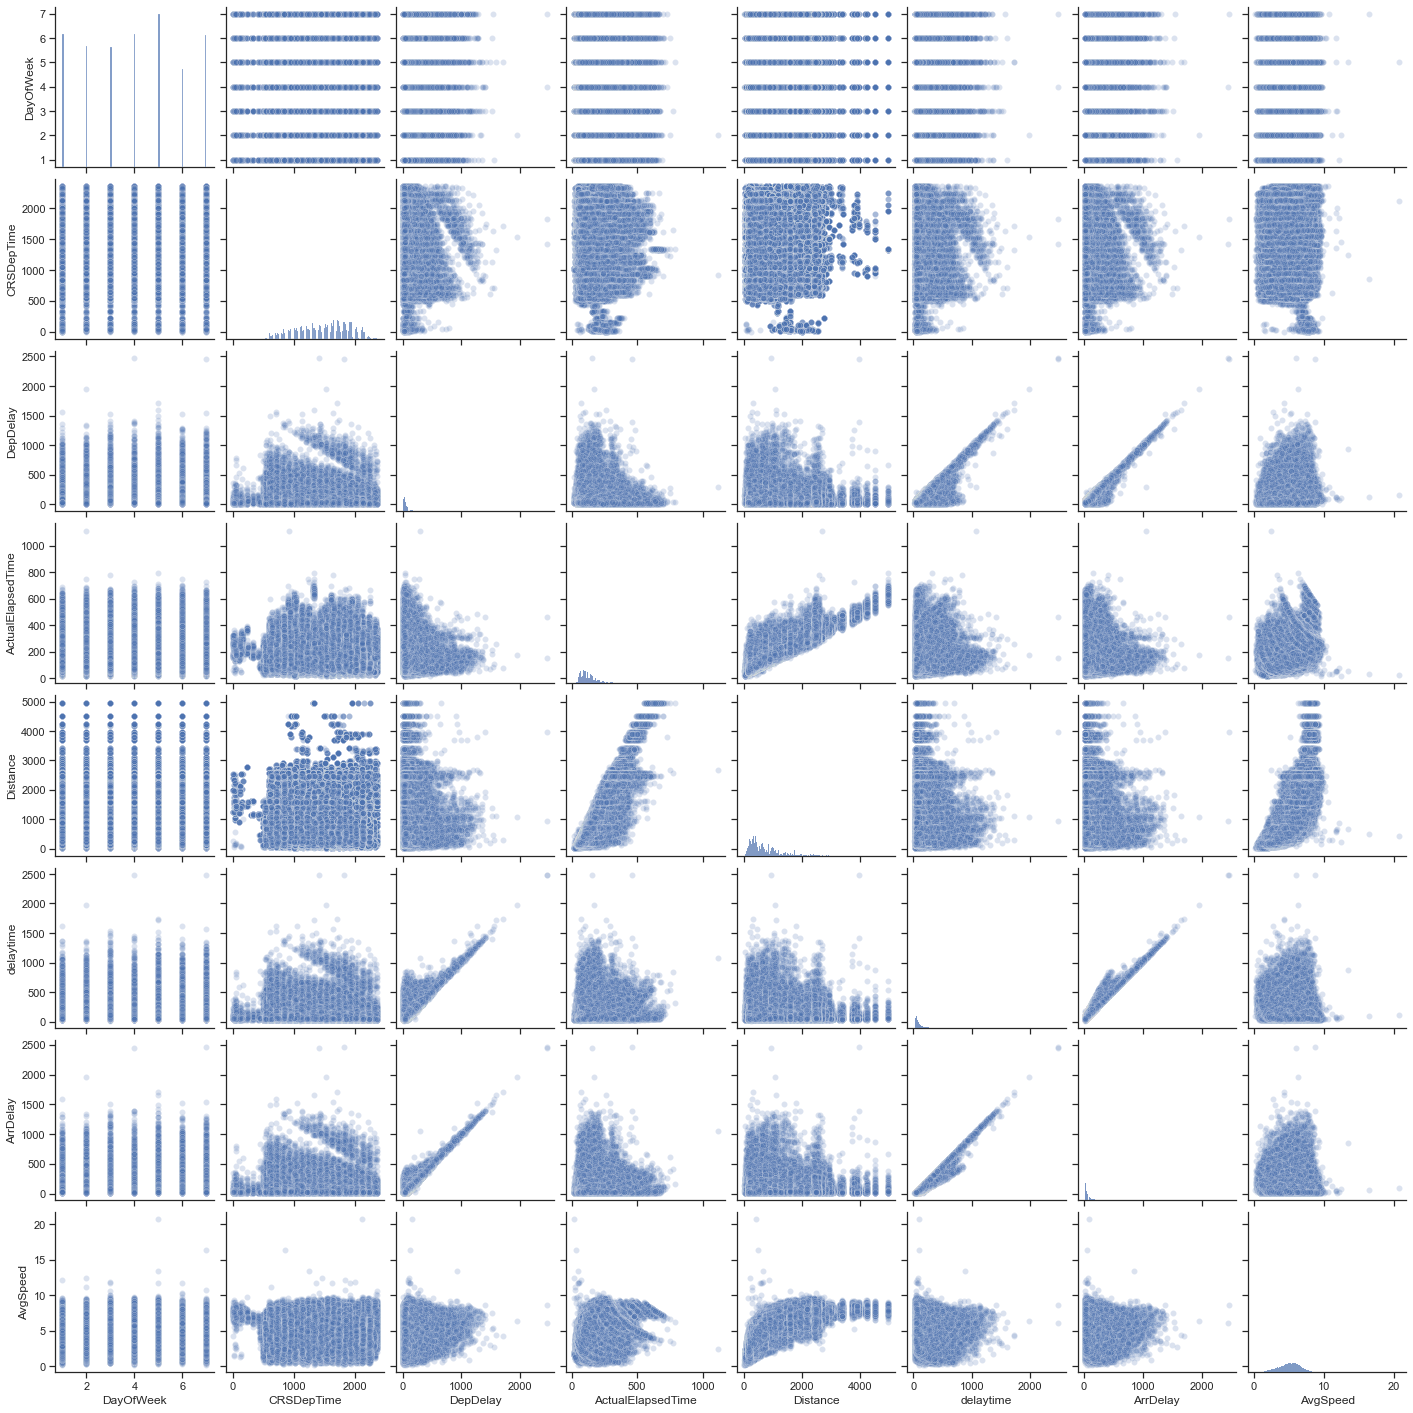

In [93]:
sns.pairplot(compactdf,diag_kind='hist', plot_kws={'alpha': 0.2})

# Exercici 6. 
##### Es regenera la variable delaytime per no contenir DepDelay i amb la velocitat mitjana s'espera fer quelcom

In [95]:
X=compactdf[['delaytime', 'ActualElapsedTime', 'AvgSpeed']] #'DepDate','DayOfWeek','CRSDepTime','Origin','Dest','Distance','delaytime' 
y=compactdf['ArrDelay']
X, y = np.array(X), np.array(y) ## els transformo en arrays de NUMPY per al model

X_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X) #transformant dades d'entrada i generant model

model = LinearRegression().fit(X_, y) #fent el model multivariable

r_sq = model.score(X_, y)
intercept, coefficients = model.intercept_, model.coef_ #dades del model
print('coefficient of determination:', r_sq)

print('intercept:', intercept)

print('coefficients:', coefficients, sep='\n')
y_pred=model.predict(X_)
mean_squared_error(y, y_pred, multioutput='raw_values')

coefficient of determination: 0.9776322327207403
intercept: -14.150423617377598
coefficients:
[ 9.19028102e-01 -5.12896813e-01  8.17635949e+00  7.04425542e-05
 -5.42938797e-04  1.89331659e-02  1.06853992e-04  6.43160231e-02
 -1.10634782e+00]


array([82.56065122])

### Aparentment ha millorat la determinació fins al 0.98 i l'error s'ha reduit fins a 82 en quadràtic. en linial a veure ...

In [96]:
X=compactdf[['delaytime', 'ActualElapsedTime', 'AvgSpeed']] #'DepDate','DayOfWeek','CRSDepTime','Origin','Dest','Distance','delaytime' 
y=compactdf['ArrDelay']
X, y = np.array(X), np.array(y) ## els transformo en arrays de NUMPY per al model

X_ = PolynomialFeatures(degree=1, include_bias=False).fit_transform(X) #transformant dades d'entrada i generant model

model = LinearRegression().fit(X_, y) #fent el model multivariable

r_sq = model.score(X_, y)
intercept, coefficients = model.intercept_, model.coef_ #dades del model
print('coefficient of determination:', r_sq)

print('intercept:', intercept)

print('coefficients:', coefficients, sep='\n')
y_pred=model.predict(X_)
mean_squared_error(y, y_pred, multioutput='raw_values')

coefficient of determination: 0.960168855432771
intercept: -36.87314938840197
coefficients:
[ 0.92732738 -0.16299927  7.48802165]


array([147.01893101])

# en linial esta bé, però es pot superar. Segurament amb alguna variable dummy fent la inversa (per la forma assimptotica)